In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt, pylab

In [2]:
total_series_length = 10000
truncated_backprop_length = 15
state_size = 4
batch_size = 1
iterations = 12000
steps_to_predict = 1
learning_rate = 0.08

In [3]:
def generate_data(length):
    x = np.linspace(0,length, length*10+1)
    y = 10*np.sin(x).reshape(1,-1)
    return(y)

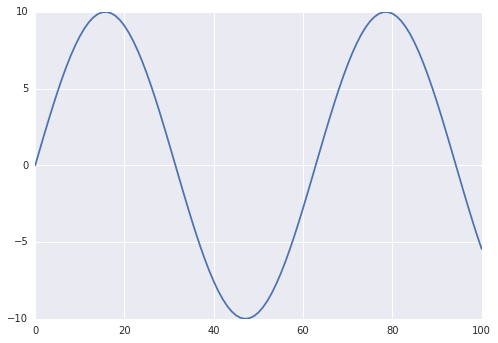

In [4]:
line_data = generate_data(10)
fig, ax = plt.subplots()
ax.plot(line_data.reshape(-1))
ax.grid(True)
ax.axis([0,100,-10,10])
plt.show()

In [5]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1)), dtype=tf.float32)

inputs_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchX_placeholder)
labels_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchY_placeholder)

In [6]:
cell = tf.contrib.rnn.core_rnn_cell.BasicRNNCell(state_size)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

In [7]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]

losses = [tf.nn.l2_loss(labels - logits, name=None) for logits, labels in zip(logits_series,labels_series)]

total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_list = []

x_data = generate_data(total_series_length)
_current_state = np.zeros(dtype=np.float32, shape=[1, 4])

for batch_idx in range(iterations):
    
    start_idx = batch_idx
    end_idx = start_idx + truncated_backprop_length

    batchX = x_data[:,start_idx:end_idx]
    batchY = x_data[:,start_idx+steps_to_predict:end_idx+steps_to_predict]

    _total_loss, _train_step, _current_state = sess.run(
        [total_loss, train_step, current_state],
        feed_dict={
            batchX_placeholder:batchX,
            batchY_placeholder:batchY,
            init_state:_current_state
        })

    loss_list.append(_total_loss)
    
    if batch_idx%(iterations/20) == 0:
        print("Step",batch_idx, "Loss", _total_loss)

('Step', 0, 'Loss', 15.42535)
('Step', 600, 'Loss', 0.81693435)
('Step', 1200, 'Loss', 0.13190526)
('Step', 1800, 'Loss', 0.18666974)
('Step', 2400, 'Loss', 0.16399516)
('Step', 3000, 'Loss', 0.10803471)
('Step', 3600, 'Loss', 0.047328766)
('Step', 4200, 'Loss', 0.050048653)
('Step', 4800, 'Loss', 0.03412015)
('Step', 5400, 'Loss', 0.044233553)
('Step', 6000, 'Loss', 0.091916256)
('Step', 6600, 'Loss', 0.08172901)
('Step', 7200, 'Loss', 0.099401459)
('Step', 7800, 'Loss', 0.059343219)
('Step', 8400, 'Loss', 0.080416031)
('Step', 9000, 'Loss', 0.051644787)
('Step', 9600, 'Loss', 0.041505389)
('Step', 10200, 'Loss', 0.028139941)
('Step', 10800, 'Loss', 0.024038529)
('Step', 11400, 'Loss', 0.027376881)


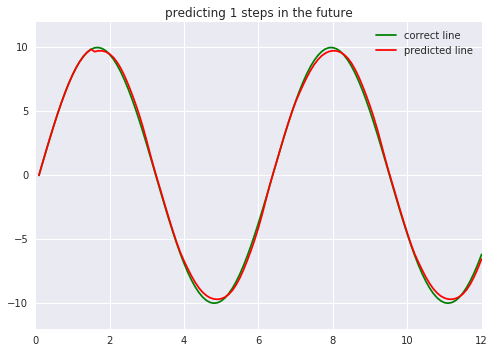

In [9]:
pred = Y = np.array([])
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])
X = np.array([])

n = 0
for i in range(120):
    Y = np.append(Y, 10*np.sin(n)).reshape(1,-1)
    
    if i < truncated_backprop_length:
        pred = np.append(pred, Y[:,-1])
        
    elif i >= truncated_backprop_length and i % steps_to_predict == 0:
        
        previous = np.array(Y[:,-(truncated_backprop_length+1):-1])
        pred = np.append(pred, sess.run([logits_series[-(steps_to_predict):truncated_backprop_length]], feed_dict={batchX_placeholder:previous, init_state:_current_state}))
        _current_state = sess.run(current_state, feed_dict={batchX_placeholder:previous, init_state:_current_state})
    
    n+= 0.1
    X = np.append(X, n)
    
Y = Y.reshape([-1])

plt.subplot()
plt.grid(True)
plt.title('predicting %s steps in the future' % steps_to_predict)
plt.plot(X,Y, 'g', label='correct line')
X = X[0:pred.size]
plt.plot(X,pred, 'r', label='predicted line')
plt.legend()
pylab.ylim([-12,12])
plt.show()